<a href="https://colab.research.google.com/github/kircherlab/MPRAsnakeflow_tutorial/blob/main/tutorial_combined.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%%capture
import matplotlib.pyplot as plt
import os
import cv2

# MPRAsnakeflow Combined (Assignment and Experiment) Tutorial

This notebook runs both the assignment and the experiment workflow. It does not use a pre-defined assignment file (mapping barcodes to oligos). Instead, it uses the output of the assignment step directly, as configured in the config file. The advantage is that more jobs can be parallelized because the oligo/barcode map is needed later in the experiment workflow. Therefore, earlier jobs can already be run. This is especially helpful if you run MPRAsnakeflow on a large HPC using a scheduling system like SLURM.

After going through the prerequisites, we will cover the config file, run MPRAsnakeflow, and look at interesting results from the assignment and experiment workflow.

## Prerequisites

### Docker/uDocker/Apptainer

When running locally, you need to install `docker` or `apptainer`. For running remotely on Google Colab, `udocker` from github.com/drengskapur/docker-in-colab works nicely.

We try to automatically find out what you need:

In [ ]:
tutorial_container = "visze/mprasnakeflow_tutorial:0.5.3"
docker= False
apptainer = False

docker = !docker --help &>/dev/null; if [ $? -eq 0 ]; then echo 1; else echo 0; fi
docker = bool(int(docker[0]))
apptainer = !apptainer --help &>/dev/null; if [ $? -eq 0 ]; then echo 1; else echo 0; fi
apptainer = bool(int(apptainer[0]))

if docker:
    print("Docker is installed! We will use Docker to run MPRAsnakeflow")
elif apptainer:
    print("Apptainer is installed! We will use Apptainer to run MPRAsnakeflow")
else:
    print("Neither Docker nor Apptainer is installed. We assume you run the tutorial on Colab and we will install uDocker for Colab")

Apptainer is installed! We will use Apptainer to run MPRAsnakeflow


When neither Docker nor Apptainer is installed, we will install uDocker for Colab now.

In [4]:
def udocker_init():
    import os
    if not os.path.exists("/home/user"):
        !pip install udocker > /dev/null
        !udocker --allow-root install > /dev/null
        !useradd -m user > /dev/null
    print(f'Docker-in-Colab 1.1.0\n')
    print(f'Usage:     udocker("--help")')
    print(f'Examples:  https://github.com/indigo-dc/udocker?tab=readme-ov-file#examples')

    def execute(command: str):
        user_prompt = "\033[1;32muser@pc\033[0m"
        print(f"{user_prompt}$ udocker {command}")
        !su - user -c "udocker $command"

    return execute

if not docker and not apptainer:
    udocker = udocker_init()

We define a general function to run our MPRAsnakeflow tutorial container that will check if Docker, Apptainer, or uDocker has to be run. It will also bind your data directory `${PWD}/MPRAsnakeflow_tutorial` (will be downloaded later) to `/data/run` within the container and defines this as the working directory.

In [5]:
def runContainer(command):
    user_prompt = "\033[1;32muser@pc\033[0m"
    if docker:
        print(f"{user_prompt}$ docker run -v=${{PWD}}/MPRAsnakeflow_tutorial:/data/run --workdir /data/run {tutorial_container} {command}")
        !docker run -v=${{PWD}}/MPRAsnakeflow_tutorial:/data/run --workdir /data/run {tutorial_container} {command}
    elif apptainer:
        print(f"apptainer run -B=${{PWD}}/MPRAsnakeflow_tutorial:/data/run --cwd /data/run mprasnakeflow_tutorial.sif {command}")
        !apptainer run -B=${{PWD}}/MPRAsnakeflow_tutorial:/data/run --cwd /data/run mprasnakeflow_tutorial.sif {command}
    else:
        udocker(f"run -v=${{PWD}}/MPRAsnakeflow_tutorial:/data/run --workdir /data/run mprasnakeflow_tutorial {command}")

### Test data

The data used in this tutorial is present in the GitHub repository. We will download it using git so that it is also present within a Colab environment.

In [6]:
%%bash
if [ ! -d "MPRAsnakeflow_tutorial" ]; then
    git clone https://github.com/kircherlab/MPRAsnakeflow_tutorial.git
else
    echo "Folder 'MPRAsnakeflow_tutorial' already exists. Skipping clone."
fi

Folder 'MPRAsnakeflow_tutorial' already exists. Skipping clone.


### snakemake

MPRAsnakeflow and its software dependencies are packed in the official snakemake v9.3.4 container, which you can find on DockerHub with the tag [`visze/mprasnakeflow_tutorial:0.5.3`](https://hub.docker.com/r/visze/mprasnakeflow_tutorial).

In [7]:
if docker:
    print(f"docker pull {tutorial_container}")
    !docker pull "{tutorial_container}"
    print(f"docker create --name=mprasnakeflow_tutorial {tutorial_container}")
    !docker create --name=mprasnakeflow_tutorial "{tutorial_container}" > /dev/null
elif apptainer:
    print(f"apptainer pull mprasnakeflow_tutorial.sif docker://{tutorial_container}")
    !apptainer pull mprasnakeflow_tutorial.sif docker://{tutorial_container} > /dev/null
else:
    udocker(f"pull {tutorial_container}")
    udocker(f"create --name=mprasnakeflow_tutorial {tutorial_container}")

apptainer pull mprasnakeflow_tutorial.sif docker://visze/mprasnakeflow_tutorial:0.5.1


FATAL:   Image file already exists: "mprasnakeflow_tutorial.sif" - will not overwrite


Try to run `snakemake --version` in the container:

In [8]:
runContainer("snakemake --version")

apptainer run -B=${PWD}/MPRAsnakeflow_tutorial:/data/run --cwd /data/run mprasnakeflow_tutorial.sif snakemake --version


9.3.5.dev0


## Combined workflow

This notebook runs both the assignment and the experiment workflow. It does not use a pre-defined assignment file (mapping barcodes to oligos). Instead, it uses the output of the assignment step directly, as configured in the config file. The advantage is that more jobs can be parallelized because the oligo/barcode map is needed later in the experiment workflow. Therefore, earlier jobs can already be run. This is especially helpful if you run MPRAsnakeflow on a large HPC using a scheduling system like SLURM.

### Assignment workflow

To analyze your MPRA data, you need to know which barcode goes with which tested sequence. This is called assignment and typically associates multiple barcodes (i.e. the sequences that you will later count in the MPRA experiment) to a target sequence. It is possible that you already designed your assignment in advance (e.g. have barcodes synthesized with the targeted sequences) and already have a file which holds for each of the designed sequences the assignment to the barcodes. If this is the case, you do not need to run the assignment step again and can run the experiment workflow with the file you already have.\
For the assignment step, we will need the files in the assignment folder (sequencing of barcodes and of the target sequences), as well as the config file and the design fasta (target sequences) in the design folder. We will take a look at these files now. The structure of a fastq file is as follows:  

```
@Sequence_ID_1  
Sequence_1  
+(Sequence_ID_1)  
Quality score string of Sequence_1
@Sequence_ID_2  
Sequence_2  
+(Sequence_ID_2)
Quality score string of Sequence_2  
...
```

In [9]:
print("First two barcodes in our barcode sequencing file:\n")
!zcat "MPRAsnakeflow_tutorial/example_data/assignment/assoc_bc.fastq.gz" | awk 'NR <=8 {print $0}'

print("\nFirst two sequences in our forward sequencing file:\n")
!zcat "MPRAsnakeflow_tutorial/example_data/assignment/assoc_fwd.fastq.gz" | awk 'NR <=8 {print $0}'

First two barcodes in our barcode sequencing file:



@NS500466:861:HT5LLAFX3:1:11101:4277:1067 2:N:0:ACGTAGACCA
TTGAGACGCCGTGAC
+
AAAAAEAEEEEEEEE
@NS500466:861:HT5LLAFX3:1:11101:13208:1071 2:N:0:ACGTAGACCA
GCAGATGTAGATTGT
+
AAAAAEEEEEEEEEE

First two sequences in our forward sequencing file:

@NS500466:861:HT5LLAFX3:1:11101:4277:1067 1:N:0:ACGTAGACCA
TCCTTTGTCTTCATTACTTGTCTCACTGGTGCAGGCCTCGCTTAGCTTTCAGCCTATCGCAGCTTTCAACCTGCCTTCCTTGCTAAGCTGAATCATTTCTGGGTTTTGATTTAAAGTGAGTCGTCGTGGCTCTTCCTTTGAGCACT
+
AAAAAEEEAEEEEEEEEEEEEEEEEEEEEEEEEEEEEEAEAEEEEAEEEEEE<EEEEAEEEEEEEEEEAEEEEEEAAE<EEEEEEEEEEAEEEEEEEEAEEEEEEEEAEEEEEEEEEEAE/EEEAEEAE<EEEEAAEEEAAE<A<A
@NS500466:861:HT5LLAFX3:1:11101:13208:1071 1:N:0:ACGTAGACCA
TATGGTTTGGCTGTGTTCCTACCCAAATCTCATCTTGAATTGTAGCTCCCACAATTCCCATGTCATGGGAGGGACCAAGTGGGAGGTAACTGAATCAGGCGGCGGGTCTTACCCCATACTGTTCTCTTGGTAGTGAATAAGTCTCA
+
AAAAAEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEAEEEEEEEE<EEEEEEEEEEEEEAEEAAEEEAEEEEAEEEEEEEEEEEE<A<<<EAEEEEEEE6AAEEEEEEEEEEEEEEEE<EEEE<EAEEEAEAE


If you take a good look at these files, you can see the sequence IDs in lines starting with "@". By definition, the sequence ID ends at the first whitespace (the remainder is considered a comment). This sequence ID is identical between the different files, i.e. the forward, reverse, and barcode reads from the same molecule are in the same order. From the combination of these files, we can see which barcode is associated with which sequenced target (forward/reverse reads). These sequenced forward/reverse reads should therefore correspond to the sequences that we designed. The designed sequences can be found in our design fasta, which contains the following information:  

```
>oligo_ID_1  
Designed sequence 1
>oligo_ID_2  
Designed sequence 2
...
```

In [10]:
!head "MPRAsnakeflow_tutorial/example_data/design/workshop_design.fa"

>oligo_002500
AGGACCGGATCAACTCTGATTGCCTGCACCTAGATGGCTTGTGTGTAGCAGGGGCTCCTGGATGAGAAGGGGGCAGAAGTTAATAGAGCTGACTCGTGCCTTGAGTGTCATGTCTTATGTATTCAGCTGCTGACTAAGCAGCAGAGTGTAATATAGCTTACTAGAAAAAGTTGACCTTTAGCTGCATTCTTAATTCTTAACTTTTCAGTTATTGACATTGCGTGAACCGA
>oligo_002501:oligo_002502
AGGACCGGATCAACTGGTAATTTATAGATTCAATGCCATCCCCATCAAGCTACCAATGACTTTCTTCCCAGAATTAGAAAAAACTACTTTAAAGTTCATATGGAACCAAAAAAGAGCCCGCATCGCCAAGTCAATCCTAAGCCAAAAGAACAAAGCTGGAGGCATCACGCTACCTGACTTCAAACTATACTACAAGGCTATGGAAATTATTTTTACATTGCGTGAACCGA
>oligo_002503
AGGACCGGATCAACTAACCTCACAATGAATCAGTGAGGTTCATATTGTTCTCCCCATTTTACAAAAAAGAGAGGTTCAGATAAATTCAGTAATTTTCTCAAGGTCACAGAACAAGTAAAGAACACAGGAGTAGTAAAAAACAGAACCAAGACTGGGACACAAGCCTCCAGCCTCCCTGGCTCAGAGCCCCTTGCTGTCTCCACTATGCCCACCATCATTGCGTGAACCGA
>oligo_002504
AGGACCGGATCAACTAGAGGCCCTGAAGAAAGGGGAAAAAGGCAGTGAAGGGGCAGAAACCCTGGTAGTCCAGCAAGGGAGGGTGAGAAGGAAGGGGGGAGGTATGAGTATTACTATAGACCAAGGGTTGGGGTGGCACCTGGAGACTCCTGGACTTGACTGCAACTGTATGTATTGTTATATGTATATGTATAGACATTTATTTTCAAGTATATCATTGCGTGAACCGA
>oligo_

"Oligos" are the target sequences that we designed in advance, i.e. the sequences we would like to see in our assignment sequencing files (fastq files). In the association step, our goal is to assign the sequences to the oligos, since as you can see the oligo ID and sequence ID are not matching. By matching the reads to our designed oligos, we also automatically link the sequenced barcodes to our designed oligos, which is essential for us later.

## Experiment Workflow

For the experiment step, where the counts per oligo are calculated, we need all the files in the `example_data/counts` folder, as well as the config file and the barcode assignment file, which is the output of the assignment step (but also stored under `example_data/counts`).

We investigated the assignment file in the association tutorial. This table is now used to count the number of observed barcodes for each target sequence.

We can take a look at the input files to understand what we later have to give the MPRAsnakeflow pipeline via a config file. Each count experiment, in our case, is described using three files (the paths of which are in the `experiment.csv` file): forward reads, reverse reads, and UMIs. Note that the UMIs are optional, and serve to deduplicate barcodes with overdispersed counts due to preferential amplification related to GC content or library preparation steps. From one of the UMI read files, we can see that indeed our UMI length is 16:

In [11]:
print("\nAverage length of a UMI:")
!zcat "MPRAsnakeflow_tutorial/example_data/counts/dna-1_S1_R2_001.fastq.gz" | awk 'NR % 4 == 2 {{sum += length($$0)}} END {{print sum*4/NR}}'


Average length of a UMI:
16


We can also check the length of the barcode, which should be 15:

In [12]:
print("\nAverage length of a barcode:")
!zcat "MPRAsnakeflow_tutorial/example_data/counts/dna-1_S1_R1_001.fastq.gz" | awk 'NR % 4 == 2 {{sum += length($$0)}} END {{print sum*4/NR}}'


Average length of a barcode:


15


## Run MPRAsnakeflow

### Snakemake

Before we come to more MPRAsnakeflow pipeline specific things, we quickly want to introduce the snakemake workflow management system. A workflow management system, also like Nextflow or CWL, is a tool to create reproducible and scalable data analyses. Snakemake workflows are described via a human-readable, Python-based language. They can be seamlessly scaled to server, cluster, grid, and cloud environments, without the need to modify the workflow definition. Finally, Snakemake workflows can entail a description of required software, which will be automatically deployed to any execution environment.

Each step in snakemake is defined as a `rule`, which has an `input`, `output`, and mostly a `shell` command. The `input` and `output` are files that are used as input and output for the rule. The `shell` command is the command that is executed to create the output file from the input file. There are other commands like `conda`, `params`, `log`, `threads`, `resources` that can be used to define the rule.

E.g. here is an example rule `assignment_check_design` of MPRAsnakeflow, which checks if the design file is correct (no duplicated header, no `[` or `]` within headers and no duplicate sequences (sense and antisense)). The rule takes our design file defined in the config (see later) and a script as input. When it is completed, it creates the file `results/assignment/{assignment}/design_check.done` and other rules will only start running when this file is present and the check is completed. `{assignment}` is a wildcard and the name of the assignment will be used here (defined in the config file). This allows us to define multiple assignments within the config file and run them in parallel. In addition, the design file is copied here: `results/assignment/{assignment}/reference/reference.fa` so that further mapping rules can create their mapping reference files. You see the `params` command is a bit lengthy but we needed some conditions, based on the flexibility of the user input. But finally, the `shell` command looks very clean.

```python
rule assignment_check_design:
    """
    Check if the design file is correct and no duplicated sequences are present (FW and reverse).
    Also check if no duplicated headers and no illegal characters in header.
    """
    conda:
        "../envs/python3.yaml"
    input:
        design=lambda wc: config["assignments"][wc.assignment]["design_file"],
        script=getScript("assignment/check_design_file.py"),
    output:
        temp("results/assignment/{assignment}/reference/reference.fa.fxi"),
        touch("results/assignment/{assignment}/design_check.done"),
        ref="results/assignment/{assignment}/reference/reference.fa",
    params:
        start=lambda wc: (
            config["assignments"][wc.assignment]["alignment_tool"]["configs"][
                "alignment_start"
            ]
            if config["assignments"][wc.assignment]["alignment_tool"]["tool"]
            == "exact"
            else config["assignments"][wc.assignment]["alignment_tool"]["configs"][
                "alignment_start"
            ]["max"]
        ),
        length=lambda wc: (
            config["assignments"][wc.assignment]["alignment_tool"]["configs"][
                "sequence_length"
            ]
            if config["assignments"][wc.assignment]["alignment_tool"]["tool"]
            == "exact"
            else config["assignments"][wc.assignment]["alignment_tool"]["configs"][
                "sequence_length"
            ]["min"]
        ),
        fast_check=lambda wc: (
            "--fast-dict"
            if config["assignments"][wc.assignment]["design_check"]["fast"]
            else "--slow-string-search"
        ),
        check_sequence_collitions=lambda wc: (
            "--perform-sequence-check"
            if config["assignments"][wc.assignment]["design_check"][
                "sequence_collitions"
            ]
            else "--skip-sequence-check"
        ),
    log:
        log=temp("results/logs/assignment/check_design.{assignment}.log"),
        err="results/assignment/{assignment}/design_check.err",
    shell:
        """
        trap "cat {log.err}" ERR
        cp {input.design} {output.ref}
        python {input.script} --input {output.ref} \
        --start {params.start} --length {params.length} \
        {params.fast_check} {params.check_sequence_collitions} > {log.log} 2> {log.err};
        """
```

When running snakemake, you need to specify where your workflow is, basically the main `Snakefile` of it. By default, Snakemake will search for ‘Snakefile’, ‘snakefile’, ‘workflow/Snakefile’, ‘workflow/snakefile’ beneath the current working directory, in this order. Then you do not have to use this command. But practically your workflow, here MPRAsnakeflow, might live somewhere else and you want to run the workflow in a different directory where you want to produce results. Then you need to specify the `--snakefile` parameter to the MPRAsnakeflow file in `workflow/Snakefile`. Otherwise, you have to check/copy the workflow in every "run" directory which is not practical. Usually, you start snakemake in the directory where you want to produce results.

### The config file

The heart of your workflow run is the config file. You can specify it via `--configfile`. It is in `yaml` or `json` format. It contains all the parameters and input files that are used in the workflow.

The config file has many parameters, but most of them have a default value, based on best practice, and you don't have to specify them. But you can overwrite them if you want. Config files are first validated using JSON schema. If your config file is not correct, MPRAsnakeflow will tell you what is missing or wrong and stop. Naming, parameters, etc. might change from MPRAsnakeflow version and you might have to update your config file if you run a new version of MPRAsnakeflow. An extensive documentation of the config file can be found in the [MPRAsnakeflow documentation](https://mprasnakeflow.readthedocs.io/en/development/config.html).

Here is the config file that we will use for running the combined tutorial.


```yaml
---
assignments:
  assignMPRAworkshop:
    bc_length: 15
    alignment_tool:
        tool: bbmap
        configs:
          sequence_length: 200
          alignment_start: 1
    FW:
      - example_data/assignment/assoc_fwd.fastq.gz
    BC:
      - example_data/assignment/assoc_bc.fastq.gz
    REV:
      - example_data/assignment/assoc_rev.fastq.gz
    design_file: example_data/design/workshop_design.fa
    configs:
      default: {}
experiments:
  experimentMPRAworkshop:
    bc_length: 15
    umi_length: 16
    data_folder: example_data/counts
    experiment_file: example_data/experiment.csv
    assignments:
      MPRAworkshop:
        type: config
        assignment_name: assignMPRAworkshop
        assignment_config: default
    label_file: example_data/design/workshop_labels.tsv
    configs:
      default: {}
      tutorialConfig:
        filter:
          bc_threshold: 5
          DNA:
            min_counts: 1
          RNA:
            min_counts: 1
```

We run both the assignment and the experiment workflow.

#### Assignment config

First, the assignment workflow config will start with `assignments`. Then a list with possible names of assignments will follow. Here we have just one: `assignMPRAworkshop`. The whole config file has the minimal information, which is needed by MPRAsnakeflow. This is the barcode length `bc_length`, the alignment tool `alignment_tool` for mapping reads to the design file (here we use `bbmap` but other options are possible) and the configuration of the tool. The forward reads `FW`, the barcode reads `BC`, the reverse reads `REV` and the design file `design_file`. Then we can define multiple configs `configs`, basically how we filter barcodes later. E.g. a minimal support of barcodes per oligo `min_support` and a fraction of assigned barcodes to an oligo `fraction`. In our tutorial example, we just have one config named `default` and we will set the default parameters by defining `default: {}`. This is `min_support: 3` and `fraction: 0.75`. But the option to have multiple settings allows us to create multiple BC to oligo mappings based on different strategies. The workflow will then only run the last part multiple times with different settings, avoiding the computationally expensive mapping approach.

As a sanity check and to understand where these values come from, we will take a look at whether the information matches our input files. We used 15 bp adapters for this MPRA experiment, which were added at both ends of each designed oligo. The `alignment_start` configuration refers to these adapters as our actual target sequences only start after the 15 bp of adapter sequence.

In [13]:
adapter_length=15

print("\nAverage length of a barcode:")
!zcat "MPRAsnakeflow_tutorial/example_data/assignment/assoc_bc.fastq.gz" | awk 'NR % 4 == 2 {{sum += length($$0)}} END {{print sum*4/NR}}'

print("\nAverage length of a target sequence (oligo length - 2 x adapter):")
seq_length_with_bc = !cat "MPRAsnakeflow_tutorial/example_data/design/workshop_design.fa" | awk 'NR % 4 == 2 {{sum +=length($$0)}} END {{print sum*4/NR}}'
seq_length_with_bc = int(seq_length_with_bc[0])
seq_length = seq_length_with_bc - 2*adapter_length
print(seq_length)


Average length of a barcode:


15

Average length of a target sequence (oligo length - 2 x adapter):
200


#### Experiment config

Everything that is written in the `experiments` part of the YAML file shows the part of the config file that concerns the experiment part. Since assignment and experiment parts can be run independently, the `bc_length` needs to be set again.

The `experiment_file` holds the path to the file of the experiment table (i.e. condition, replicate and name of read files given).

Because we run the experiment workflow, we start with `experiments`. Then a list with possible names of experiments will follow. Here we have just one: `experimentMPRAworkshop`. The whole config file has the minimal information, which is needed by MPRAsnakeflow (except for `configs`, see later). This is the barcode length `bc_length` and the UMI length `umi_length` which we calculated previously. Then a link to folder `data_folder` where all fastqs of the experiment are. What conditions, replicates and belonging fastq files we have is stored in the `experiment_file`.

As a sanity check and to understand where these values come from, we will take a look at whether the information matches our input files. We used 15 bp adapters for this MPRA experiment, which were added at both ends of each designed oligo. The `alignment_start` configuration refers to these adapters as our actual target sequences only start after the 15 bp of adapter sequence.

In [14]:
adapter_length=15

print("\nAverage length of a barcode:")
!zcat "MPRAsnakeflow_tutorial/example_data/assignment/assoc_bc.fastq.gz" | awk 'NR % 4 == 2 {{sum += length($$0)}} END {{print sum*4/NR}}'

print("\nAverage length of a target sequence (oligo length - 2 x adapter):")
seq_length_with_bc = !cat "MPRAsnakeflow_tutorial/example_data/design/workshop_design.fa" | awk 'NR % 4 == 2 {{sum +=length($$0)}} END {{print sum*4/NR}}'
seq_length_with_bc = int(seq_length_with_bc[0])
seq_length = seq_length_with_bc - 2*adapter_length
print(seq_length)


Average length of a barcode:


15

Average length of a target sequence (oligo length - 2 x adapter):
200


In the `assignments` part of the YAML we link back towards the assignment workflow and specify which assignment run we should use and under which config. This part is different to the stand-alone experiment tutorial because here we use an assignment file.

### MPRAsnakeflow tutorial profile

Snakemake can make use of profiles to pre-configure command-line interfaces as well as resources and number of threads as default or per rule. A profile has to be stored (on Linux) in the folder `$HOME/.config/snakemake` or `/etc/xdg/snakemake`. It can be activated by using the `--profile` option in the snakemake command. In addition, you can set an environment variable `SNAKEMAKE_PROFILE`, e.g. by specifying `export SNAKEMAKE_PROFILE=myprofile` in your `~/.bashrc` to use the profile by default. In addition, a specific workflow profile can be set using `--workflow-profile path_to_your_profile`. E.g. we pre-defined a [workflow profile for MPRAsnakeflow](https://github.com/kircherlab/MPRAsnakeflow/blob/development/profiles/default/config.yaml) adding resources to each rule with some additional commands for the [snakemake executor plugin slurm](https://snakemake.github.io/snakemake-plugin-catalog/plugins/executor/slurm.html).

For more information on snakemake using profiles, please have a look at the [snakemake profile documentation](https://snakemake.readthedocs.io/en/stable/executing/cli.html#profiles).

For the MPRAsnakeflow tutorial, we will use the profile `mprasnakeflow` which is stored in the folder `/etc/xdg/snakemake` within the container and the `SNAKEMAKE_PROFILE=mprasnakeflow` is already set. Have a look at the variable and the profile:

In [15]:
runContainer("cat /etc/xdg/snakemake/mprasnakeflow/config.yaml")

apptainer run -B=${PWD}/MPRAsnakeflow_tutorial:/data/run --cwd /data/run mprasnakeflow_tutorial.sif cat /etc/xdg/snakemake/mprasnakeflow/config.yaml


---
snakefile: /data/MPRAsnakeflow/workflow/Snakefile
software-deployment-method: conda
conda-prefix: /data/conda_envs
cores: 1
set-threads:
  assignment_mapping_bbmap: 10


You see that we already defined where the MPRAsnakeflow `Snakefile` is and `--snakefile` is not necessary. Also, all software packages are installed already in the container using conda and we enable this software deployment method and tell snakemake where the conda environments live (the default will be your execution folder under `.snakemake/conda`). Also, the `--cores/-c` option is not necessary anymore and snakemake just needs your configuration file of the workflow using the command `--configfile`

### Run the workflow

First, we run a dry-run to see what will be executed using `-n` and `--quiet rules` to see only the overview of executed rules and not each rule command individually. The most important part is setting the config file via `--configfile config_combined.yaml`

In [ ]:
# MPRAsnakeflow_tutorial must be accessible and writable for all (and docker)
!chmod ugo+rwx MPRAsnakeflow_tutorial
# Run MPRAsnakeflow
runContainer("snakemake --configfile config_combined.yaml -n --quiet rules")

apptainer run -B=${PWD}/MPRAsnakeflow_tutorial:/data/run --cwd /data/run mprasnakeflow_tutorial.sif snakemake --configfile config_combined.yaml -n --quiet rules
Using profile mprasnakeflow for setting default command line arguments.
Running MPRAsnakeflow version 0.5.1
host: pmn-bih-cfbi-20
Building DAG of jobs...
IncompleteFilesException:
The files below seem to be incomplete. If you are sure that certain files are not incomplete, mark them as complete with

    snakemake --cleanup-metadata <filenames>

To re-generate the files rerun your command with the --rerun-incomplete flag.
Incomplete files:
results/assignment/assignMPRAworkshop/fastq/merge_split0.un.fastq.gz
results/assignment/assignMPRAworkshop/fastq/merge_split0.join.fastq.gz


You see a list of rules and how often this rule is executed depending on the input file. E.g. it is possible to split your input fastq file into `n` via the rule `assignment_fastq_split` using the option `split_number` in the config file (it is commented out right now). Then rules afterwards, like `assignment_getBCs`, will be executed `n` times. This behaviour is nice for parallelisation, especially on an HPC system where you have multiple nodes available. 

A short summary of each rule is in the [MPRAsnakeflow documentation](https://mprasnakeflow.readthedocs.io/en/latest/assignment.html#rules).

Now let's run snakemake using 10 cores (BBMap can be parallelized). When you add the `-p` flag you will see the exact code that is executed in each rule. But we omit this here because it is a lot of output.

In [17]:
runContainer("snakemake --configfile config_combined.yaml -c 10")

apptainer run -B=${PWD}/MPRAsnakeflow_tutorial:/data/run --cwd /data/run mprasnakeflow_tutorial.sif snakemake --configfile config_combined.yaml -c 10


Using profile mprasnakeflow for setting default command line arguments.
Running MPRAsnakeflow version 0.5.1
Assuming unrestricted shared filesystem usage.
host: pmn-bih-cfbi-20
Building DAG of jobs...
IncompleteFilesException:
The files below seem to be incomplete. If you are sure that certain files are not incomplete, mark them as complete with

    snakemake --cleanup-metadata <filenames>

To re-generate the files rerun your command with the --rerun-incomplete flag.
Incomplete files:
results/assignment/assignMPRAworkshop/fastq/merge_split0.un.fastq.gz
results/assignment/assignMPRAworkshop/fastq/merge_split0.join.fastq.gz


## Results

First we go through the assignment and afterwards through the experiment results.

### Assignment results

Let's take a look at the files in the assignment results folder!

In [18]:
results_dir = "MPRAsnakeflow_tutorial/results/assignment"
!ls -R "{results_dir}"

MPRAsnakeflow_tutorial/results/assignment:
assignMPRAworkshop

MPRAsnakeflow_tutorial/results/assignment/assignMPRAworkshop:
design_check.done  design_check.err  fastq  reference

MPRAsnakeflow_tutorial/results/assignment/assignMPRAworkshop/fastq:
merge_split0.join.fastq.gz  merge_split0.un.fastq.gz  splits

MPRAsnakeflow_tutorial/results/assignment/assignMPRAworkshop/fastq/splits:
FW.split0.BCattached.fastq.gz  REV.split0.BCattached.fastq.gz

MPRAsnakeflow_tutorial/results/assignment/assignMPRAworkshop/reference:
reference.fa


The statistic folder contains run statistics for the assignment step, such as the total number of associated barcodes, the number of oligos with at least 15 barcodes, and more. We will now just take a look at the generated count histogram of barcodes per oligo.

In [19]:
img = plt.imread(os.path.join(results_dir, "assignMPRAworkshop/statistic/assignment.default.png"))
plt.imshow(img)
plt.axis("off")

FileNotFoundError: [Errno 2] No such file or directory: 'MPRAsnakeflow_tutorial/results/assignment/assignMPRAworkshop/statistic/assignment.default.png'

The median number of barcodes is 24. We usually require each tested sequence to have at least 10 barcodes associated.

We will now take a look at the actual output file of the assignment run, which is a sorted table of `barcodes`, their assigned `sequence IDs`, information about the `quality` of the alignment (fwd/rev reads to designed oligos), and how often this barcode was assigned to this sequence compared to the total number this barcode was observed in the experiment. The information in the quality field is derived from the SAM/BAM output (https://samtools.github.io/hts-specs/SAMv1.pdf) and represents a concatenation of the SAM position, cigar, NM, AM, and mapQ.

In [ ]:
assignment = os.path.join(results_dir, "assignMPRAworkshop/assignment_barcodes.default.tsv.gz")
!zcat "{assignment}" | awk 'NR <= 10 {{print $$0}}'

AAAAAAAAAGAAGGG	oligo_006589	16;200=;NM:i:0;AM:i:45;45	5/5
AAAAAAAAATCGATC	oligo_006917	16;161=1X38=;NM:i:1;AM:i:44;44	3/3
AAAAAAAAATGATCT	oligo_211468	16;190=1X9=;NM:i:1;AM:i:44;44	4/4
AAAAAAAACACATGA	oligo_005412	16;200=;NM:i:0;AM:i:45;45	3/3
AAAAAAAACAGTAAG	oligo_006290	16;200=;NM:i:0;AM:i:45;45	3/3
AAAAAAAACATAGTT	oligo_006471	16;200=;NM:i:0;AM:i:45;45	3/3
AAAAAAAACCAAATA	oligo_189277	16;200=;NM:i:0;AM:i:45;45	3/3
AAAAAAAACGAACAG	oligo_005299	16;200=;NM:i:0;AM:i:45;45	3/3
AAAAAAAACTATGTT	oligo_005948	16;200=;NM:i:0;AM:i:45;45	3/3
AAAAAAAAGAAAAAG	oligo_144933	17;199=;NM:i:0;AM:i:45;45	3/3


We would like to know how many different oligos have been included in the final assignment.\
When we compare this number to the number of sequences in our design, we can get a feeling of how many sequences were able to get assigned with their barcodes. This has implications for the proportion of targets that we can eventually analyse and whether each target is supported with sufficiently many barcodes. This information is important for the experiment overall and analyzing the counts of each individual replicate.

In [ ]:
assigned_sequences = !zcat "{assignment}" | awk -F'\t' '{{names[$$2]++}} END {{print length(names)}}'

assigned_sequences = int(assigned_sequences[0])
print("Number of sequences we were able to assign: %s"%(assigned_sequences))

designed_sequences = !cat "MPRAsnakeflow_tutorial/example_data/design/workshop_design.fa" | grep -v ">" | wc -l
designed_sequences = int(designed_sequences[0])
print("Number of sequences in the initial design: %s"%(designed_sequences))

print(r"Conclusion: %s%% sequences of our initial design can be used in the experimental/counting step"%(round(assigned_sequences/designed_sequences * 100, 1)))

Number of sequences we were able to assign: 2060
Number of sequences in the initial design: 2104
Conclusion: 97.9% sequences of our initial design can be used in the experimental/counting step


### Experiment results

Let's take a look at the files in the experiment results folder!

In [ ]:
results_dir = "MPRAsnakeflow_tutorial/results/experiments"
!ls -R "{results_dir}"

MPRAsnakeflow_tutorial/results/experiments:
experimentMPRAworkshop

MPRAsnakeflow_tutorial/results/experiments/experimentMPRAworkshop:
assigned_counts  qc_report.HepG2.MPRAworkshop.default.html
assignment	 qc_report.HepG2.MPRAworkshop.tutorialConfig.html
counts		 statistic

MPRAsnakeflow_tutorial/results/experiments/experimentMPRAworkshop/assigned_counts:
MPRAworkshop

MPRAsnakeflow_tutorial/results/experiments/experimentMPRAworkshop/assigned_counts/MPRAworkshop:
HepG2_1.merged.config.default.tsv.gz
HepG2_1.merged.config.tutorialConfig.tsv.gz
HepG2_1_DNA_final_counts.config.default.tsv.gz
HepG2_1_DNA_final_counts.config.tutorialConfig.tsv.gz
HepG2_1_RNA_final_counts.config.default.tsv.gz
HepG2_1_RNA_final_counts.config.tutorialConfig.tsv.gz
HepG2_2.merged.config.default.tsv.gz
HepG2_2.merged.config.tutorialConfig.tsv.gz
HepG2_2_DNA_final_counts.config.default.tsv.gz
HepG2_2_DNA_final_counts.config.tutorialConfig.tsv.gz
HepG2_2_RNA_final_counts.config.default.tsv.gz
HepG2_2_RNA_final_co

We can take a look at the amount of barcodes that have been removed due to UMI collision, by checking how many unique BC x UMI combinations we have in our data. (We are now checking the RNA counts in replicate 1, but we should look at both DNA and RNA counts in all three replicates.)

In [ ]:
print("First few lines of a count file, where column 1 contains the barcode, 2 the UMI and 3 the count.")
!zcat "{results_dir}"/experimentMPRAworkshop/counts/HepG2_1_RNA_filtered_counts.tsv.gz | awk 'NR <= 10 {{print}}'

print("\nAmount of total BC x UMI combinations:")
!zcat "{results_dir}"/experimentMPRAworkshop/counts/HepG2_1_RNA_filtered_counts.tsv.gz | wc -l

print("\nAmount of duplicate BC x UMI combinations (the file is sorted):")
!zcat "{results_dir}"/experimentMPRAworkshop/counts/HepG2_1_RNA_filtered_counts.tsv.gz | uniq -d | wc -l

First few lines of a count file, where column 1 contains the barcode, 2 the UMI and 3 the count.
AAAAAAAAAAAAAAA	CGAAGTACACTTTCCG	1
AAAAAAAAAAAAAGG	CGTGAGCAGGATTAAG	1
AAAAAAAAAACAAGT	CTATCCGCACTGTGTC	1
AAAAAAAAAACCCAA	TTCCTAGGGACAGTCC	1
AAAAAAAAAAGATGC	GGAGCATGTAATGGGT	1
AAAAAAAAAAGCTGC	AAGATATACGGACGAT	1
AAAAAAAAAAGCTGC	AGAGGTTAGAAGGGCA	1
AAAAAAAAAAGCTGC	ATATGGACCGCCCTGG	1
AAAAAAAAAAGCTGC	CATGCACCCTGCATAA	1
AAAAAAAAAAGCTGC	CTGATTGTACCGCAGC	1

Amount of total BC x UMI combinations:
871822

Amount of duplicate BC x UMI combinations (the file is sorted):
0


There are no collisions, indicating that this subset of the data is of high quality. Great!

The count files are then joined with the assignment file (the output of the assignment step) to assign counts to oligos. The barcode counts are then aggregated over the oligos. This is done within MPRAsnakeflow with additional filter steps, but to give you a feeling of what's happening we give you some simplified code below:

In [ ]:
counts_rep1 = os.path.join(results_dir, "experimentMPRAworkshop/assigned_counts/MPRAworkshop/HepG2_1.merged.config.tutorialConfig.tsv.gz")
assignment = "MPRAsnakeflow_tutorial/example_data/assignment/assignment_barcodes.default.tsv.gz"

print("Joining the assignment and the counts of replicate 1:\n\nBarcode\toligo\tDNA\tRNA")
!join <(zcat {assignment}) <(zcat {counts_rep1}) -t $'\t' | cut -f 1,2,5-6 | awk 'NR <= 10 {{print}}'

print("\nAggregating the barcodes over oligos and the counts of replicate 1:\n\noligo\tDNA\tRNA")
!join <(zcat {assignment}) <(zcat {counts_rep1}) -t $'\t' | cut -f 1,2,5-6 | sort -k2,2 | \
 awk -v OFS="\t" '{{if ($$2 == prev) {{dna += $$3; rna += $$4}} else {{ if (NR > 1) print prev,dna,rna; prev=$$2; dna=$$3;rna=$$4}}}}' | awk 'NR <= 10 {{print}}'

Joining the assignment and the counts of replicate 1:

Barcode	oligo	DNA	RNA
AAAAAAAAATCGATC	oligo_006917	2	3
AAAAAAAACACATGA	oligo_005412	10	4
AAAAAAAACAGTAAG	oligo_006290	4	3
AAAAAAAACCAAATA	oligo_189277	4	2
AAAAAAAACGAACAG	oligo_005299	4	1
AAAAAAAAGAATTAC	oligo_144932	4	4
AAAAAAAAGAGTAGT	oligo_006091	7	10
AAAAAAACCGCACAT	oligo_005747	1	4
AAAAAAAGACCTAAG	oligo_006429	1	4
AAAAAAAGAGGTAAA	oligo_006350	4	6

Aggregating the barcodes over oligos and the counts of replicate 1:

oligo	DNA	RNA
oligo_002500	23	41
oligo_002501:oligo_002502	11	26
oligo_002503	14	23
oligo_002504	1	2
oligo_002505	23	40
oligo_002506	7	15
oligo_002507	11	21
oligo_002508	11	29
oligo_002510	15	32
oligo_002511	24	29


In the next steps, barcodes are already aggregated to their oligos/targets.  
  
We will have a look at the correlation plots between the replicates for DNA and RNA now. Typically, we will sequence RNA counts deeper than DNA -- because of the larger dynamic range of RNA. We therefore expect that the correlation of RNA counts is higher than that of the DNA. Our example data shows this trend as well.

We have a correlation of DNA counts per insert between the replicates of 0.29 and 0.30. This correlation is for a subset of the complete MPRA experiment. The shown output uses the user set minThreshold for removing barcodes with too few counts. In order to see the influence of the parameter another plot is generated without this threshold.

With the threshold of 5 barcodes per oligo and at least one DNA and RNA count
- DNA correlation: 0.29 - 0.30
- RNA correlation: 0.68 - 0.70

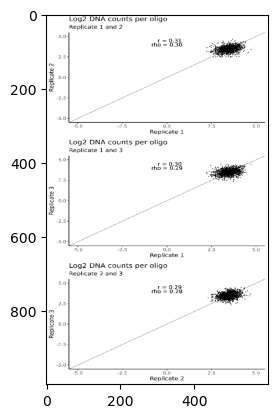

In [ ]:
dna_pairwise = cv2.imread(f'{results_dir}/experimentMPRAworkshop/statistic/assigned_counts/MPRAworkshop/tutorialConfig/HepG2_DNA_pairwise_minThreshold.png')

dna_pairwise_resize = cv2.resize(dna_pairwise, (600, 1000))

plt.imshow(dna_pairwise_resize)
plt.show()

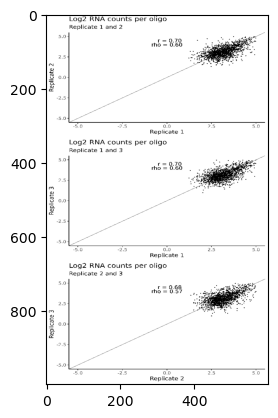

In [ ]:
rna_pairwise = cv2.imread(f'{results_dir}/experimentMPRAworkshop/statistic/assigned_counts/MPRAworkshop/tutorialConfig/HepG2_RNA_pairwise_minThreshold.png')

rna_pairwise_resize = cv2.resize(rna_pairwise, (600, 1000))

plt.imshow(rna_pairwise_resize)
plt.show()

In the following two figures you can see that this trend continues for a threshold of 10 barcodes per insert.
- DNA correlation: 0.32 - 0.39
- RNA correlation: 0.79 - 0.80

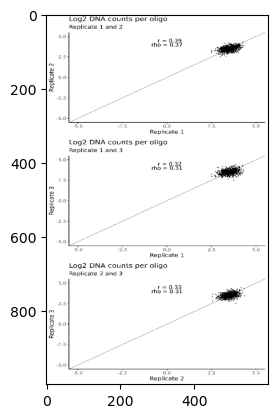

In [ ]:
dna_pairwise_no_thresh = cv2.imread(f'{results_dir}/experimentMPRAworkshop/statistic/assigned_counts/MPRAworkshop/default/HepG2_DNA_pairwise_minThreshold.png')

dna_pairwise_no_thresh_resize = cv2.resize(dna_pairwise_no_thresh, (600, 1000))

plt.imshow(dna_pairwise_no_thresh_resize)
plt.show()

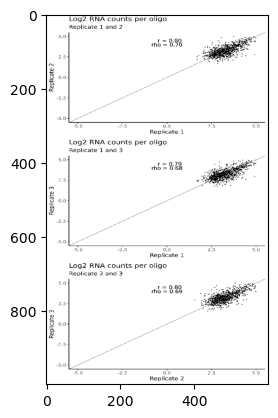

In [ ]:
rna_pairwise_no_thresh = cv2.imread(f'{results_dir}/experimentMPRAworkshop/statistic/assigned_counts/MPRAworkshop/default/HepG2_RNA_pairwise_minThreshold.png')

rna_pairwise_no_thresh_resize = cv2.resize(rna_pairwise_no_thresh, (600, 1000))

plt.imshow(rna_pairwise_no_thresh_resize)
plt.show()

Even though it is a small example, the minimal barcode count threshold shows a clear effect on correlation. However, we also note that we are losing a proportion of oligos with these strict filters and thereby limit the conclusions that we can draw from the data.

Now we want to go through the final output of MPRAsnakeflow: the count table of sequences and barcodes together with their aggregated log2 values. Note that there are no statistics calculated at this step yet, the table doesn't say anything about certainty/variance of the activity. The log2 value refers to the log2 ratio of RNA counts over DNA counts for each oligo, which is a measurement of the activity of the target sequence. More on this in the statistical analysis tutorial.

In [ ]:
!zcat {results_dir}/experimentMPRAworkshop/assigned_counts/MPRAworkshop/tutorialConfig/HepG2_allreps_merged.tsv.gz | awk 'NR <= 10 {{print}}'

condition	replicate	name	dna_counts	rna_counts	dna_normalized	rna_normalized	ratio	log2	n_obs_bc
HepG2	1	no_BC	150588	394586	9.92016075598502	9.72613704702904	1.26892422325652	0.34360592	71597
HepG2	1	oligo_002500	23	41	13.5600415055183	9.04455923436262	0.863257582487873	-0.21213699	8
HepG2	1	oligo_002501:oligo_002502	15	28	8.84350532968588	6.17677216005252	0.903964037597058	-0.14566272	8
HepG2	1	oligo_002503	19	31	8.96141873408169	5.4708553417608	0.790118942636526	-0.33985825	10
HepG2	1	oligo_002504	1	2	4.71653617583247	3.52958409145858	0.968532897425419	-0.04612704	1
HepG2	1	oligo_002505	23	40	13.5600415055183	8.82396022864646	0.842202519500364	-0.2477609	8
HepG2	1	oligo_002506	22	64	14.8233994097592	16.1352415609535	1.40877512352788	0.49444134	7
HepG2	1	oligo_002507	39	36	26.2778444082095	9.07607337803636	0.447015183427116	-1.16160426	7
HepG2	1	oligo_002508	12	30	9.43307235166494	8.82396022864646	1.21066612178177	0.27580105	6


### QC report

We have a QC report for the assignment as well as for the experiment workflow. The QC report gives a nice overview of the assignment run and might be the first thing you will look at. 

For our assignment run you can find it here:

[MPRAsnakeflow_tutorial/results/assignment/assignMPRAworkshop/qc_report.default.html](MPRAsnakeflow_tutorial/results/assignment/assignMPRAworkshop/qc_report.default.html)

For our experiment run you can find it here:

- [MPRAsnakeflow_tutorial/results/experiments/experimentMPRAworkshop/qc_report.HepG2.MPRAworkshop.default.html](MPRAsnakeflow_tutorial/results/experiments/experimentMPRAworkshop/qc_report.HepG2.MPRAworkshop.default.html) - 10 BC threshold

- [MPRAsnakeflow_tutorial/results/experiments/experimentMPRAworkshop/qc_report.HepG2.MPRAworkshop.tutorialConfig.html](MPRAsnakeflow_tutorial/results/experiments/experimentMPRAworkshop/qc_report.HepG2.MPRAworkshop.tutorialConfig.html) - 5 BC threshold

In [ ]:
from IPython.display import IFrame

IFrame(src='./MPRAsnakeflow_tutorial/results/assignment/assignMPRAworkshop/qc_report.default.html', width=700, height=600)

IFrame(src='./MPRAsnakeflow_tutorial/results/experiments/experimentMPRAworkshop/qc_report.HepG2.MPRAworkshop.default.html', width=700, height=600)

IFrame(src='./MPRAsnakeflow_tutorial/results/experiments/experimentMPRAworkshop/qc_report.HepG2.MPRAworkshop.tutorialConfig.html', width=700, height=600)